## Imports & Configuration

We import all necessary libraries, set up warnings, and define helper functions for reproducibility and plotting

In [36]:
# Imports & configuration
import os
import re
import json
import math
import string
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)
import joblib

# Settings
RANDOM_STATE = 42
CV_FOLDS = 5
SAVEDIR = Path("artifacts")
SAVEDIR.mkdir(exist_ok=True)
sns.set(style="whitegrid")
np.random.seed(RANDOM_STATE)

## Load Dataset

Load the CSV and show top rows and quick summaries

In [37]:
# load dataset
DATA_PATH = "/content/sample_data/judge-1377884607_tweet_product_company.csv"
df = pd.read_csv(DATA_PATH, encoding="latin1")

In [38]:
df.shape

(9093, 3)

In [39]:
df.columns.tolist()

['tweet_text',
 'emotion_in_tweet_is_directed_at',
 'is_there_an_emotion_directed_at_a_brand_or_product']

In [40]:
display(df.head())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [41]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


None

## Quick label inspection and cleaning plan

Inspect target label distribution and nulls; define allowed labels and show counts

In [42]:
# Inspect labels and missing values
label_col = "is_there_an_emotion_directed_at_a_brand_or_product"
text_col = "tweet_text"

In [43]:
print("Missing in text:", df[text_col].isna().sum())
print("Missing in label:", df[label_col].isna().sum())
print("\nLabel value counts:")
vc = df[label_col].value_counts(dropna=False)
display(vc)

Missing in text: 1
Missing in label: 0

Label value counts:


,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5389
Positive emotion,2978
Negative emotion,570
I can't tell,156


In [44]:
# Keep the set of labels present (we'll filter to these - avoids odd values)
allowed_labels = vc.index.tolist()
print("\nAllowed labels (detected):", allowed_labels)


Allowed labels (detected): ['No emotion toward brand or product', 'Positive emotion', 'Negative emotion', "I can't tell"]


## Text cleaning function

Define a conservative text cleaner: remove URLs, normalize mentions, keep hashtags as tokens, and remove excessive whitespace. This preserves tokens useful for stakeholders.

In [45]:
# Basic text cleaning function (conservative)
URL_RE = re.compile(r"https?://\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
NON_ALPHANUMERIC_RE = re.compile(r"[^\w\s#@']")

def clean_text_basic(text):
    if not isinstance(text, str):
        return ""
    t = text
    t = URL_RE.sub(" ", t)
    t = USER_RE.sub(" @user ", t)            # normalize mentions
    t = HASHTAG_RE.sub(r" hashtag_\1 ", t)  # preserve hashtag token
    t = NON_ALPHANUMERIC_RE.sub(" ", t)     # drop punctuation except underscores (keeps hashtags)
    t = re.sub(r"\s+", " ", t).strip()
    return t.lower()

In [46]:
# Quick check
sample_text = df[text_col].dropna().astype(str).iloc[0]
print("Original:", sample_text)
print("Cleaned :", clean_text_basic(sample_text))

Original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned : @user i have a 3g iphone after 3 hrs tweeting at hashtag_rise_austin it was dead i need to upgrade plugin stations at hashtag_sxsw


## Apply cleaning, filter labels, and split

Apply cleaning, drop rows with missing text or labels, restrict to detected labels, and create stratified train/val/test splits.

In [47]:
# Prepare dataframe
df = df.dropna(subset=[text_col, label_col]).copy()
df["clean_text"] = df[text_col].map(clean_text_basic)

In [48]:
# Filter to allowed labels detected earlier (defensive)
df = df[df[label_col].isin(allowed_labels)].reset_index(drop=True)

In [49]:
# Train / validation / test split (80/10/10 stratified)
X = df["clean_text"].values
y = df[label_col].values

In [50]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Train label distribution:\n", pd.Series(y_train).value_counts(normalize=True))

Train: 7273 Val: 909 Test: 910
Train label distribution:
 No emotion toward brand or product    0.592603
Positive emotion                      0.327513
Negative emotion                      0.062698
I can't tell                          0.017187
Name: proportion, dtype: float64


## EDA, label distribution and length

Visualize class balance and tweet length distribution to communicate dataset characteristics to stakeholders.

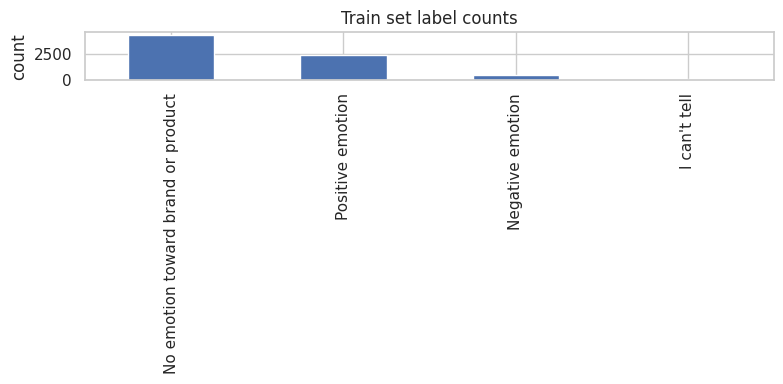

In [51]:
# Plot label distribution (train)
plt.figure(figsize=(8,4))
pd.Series(y_train).value_counts().plot(kind="bar")
plt.title("Train set label counts")
plt.ylabel("count")
plt.tight_layout()
plt.show()

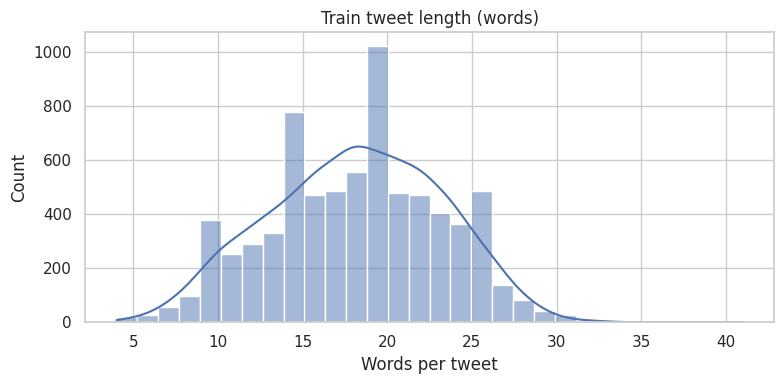

In [52]:
# Tweet length (word count)
def word_count(s): return len(str(s).split())
train_lengths = [word_count(t) for t in X_train]
plt.figure(figsize=(8,4))
sns.histplot(train_lengths, bins=30, kde=True)
plt.title("Train tweet length (words)")
plt.xlabel("Words per tweet")
plt.tight_layout()
plt.show()

## Quick top tokens per label

Show top unigrams for each class using TF-IDF-like frequency — useful to quickly explain what each class talks about.

In [53]:
# Top tokens per label (simple frequency-based)
from sklearn.feature_extraction.text import CountVectorizer

def top_tokens_for_label(texts, n=15):
    vec = CountVectorizer(ngram_range=(1,1), stop_words="english", min_df=2)
    Xc = vec.fit_transform(texts)
    sums = np.asarray(Xc.sum(axis=0)).ravel()
    tokens = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(sums)[::-1][:n]
    return list(zip(tokens[top_idx], sums[top_idx]))

labels = pd.Series(y_train).unique().tolist()
print("Top tokens per label (train subset):")
for lab in labels:
    texts = [t for t,l in zip(X_train, y_train) if l == lab]
    tops = top_tokens_for_label(texts, n=10)
    print(f"\n{lab} (n={len(texts)})")
    print(", ".join([f"{tok}({cnt})" for tok,cnt in tops]))


Top tokens per label (train subset):

No emotion toward brand or product (n=4310)
hashtag_sxsw(4317), user(3630), link(2369), rt(1488), google(1182), ipad(890), apple(821), quot(782), store(705), new(547)

Negative emotion (n=456)
hashtag_sxsw(456), user(258), quot(145), ipad(135), iphone(120), google(116), rt(113), link(89), apple(88), app(47)

Positive emotion (n=2382)
hashtag_sxsw(2398), user(1781), link(968), ipad(760), rt(745), apple(613), google(524), store(450), quot(383), iphone(370)

I can't tell (n=125)
hashtag_sxsw(126), user(79), google(40), link(37), ipad(31), apple(29), rt(29), quot(26), iphone(25), store(20)


## Baseline pipeline: TF-IDF and Logistic Regression

In [54]:
# Baseline pipeline and CV scoring
baseline_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=0.95)),
    ("clf", LogisticRegression(multi_class="multinomial", solver="saga", max_iter=1000,
                               class_weight="balanced", random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
baseline_cv_scores = cross_val_score(baseline_pipe, X_train, y_train, scoring="f1_macro", cv=cv, n_jobs=-1)
print("Baseline CV macro-F1 (mean ± std):", f"{baseline_cv_scores.mean():.4f} ± {baseline_cv_scores.std():.4f}")

Baseline CV macro-F1 (mean ± std): 0.2083 ± 0.1118


In [55]:
# Fit on full train and evaluate on validation
baseline_pipe.fit(X_train, y_train)
y_val_pred_baseline = baseline_pipe.predict(X_val)
print("\nValidation classification report (baseline):")
print(classification_report(y_val, y_val_pred_baseline, digits=4))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Validation classification report (baseline):
                                    precision    recall  f1-score   support

                      I can't tell     0.0252    0.2000    0.0448        15
                  Negative emotion     0.1182    0.6491    0.2000        57
No emotion toward brand or product     0.7465    0.3989    0.5200       539
                  Positive emotion     0.5767    0.3658    0.4476       298

                          accuracy                         0.4004       909
                         macro avg     0.3667    0.4034    0.3031       909
                      weighted avg     0.6396    0.4004    0.4683       909



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Improved model: TF-IDF (word+char ngrams) and LinearSVC with GridSearch

Use a stronger text representation with word n-grams and character n-grams, tuned LinearSVC. GridSearch is limited but meaningful.

In [56]:
# Improved pipeline and parameter tuning
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE, max_iter=5000))
])

param_grid = {
    "tfidf__ngram_range": [(1,2), (1,3)],
    "tfidf__min_df": [2,3],
    "clf__C": [0.5, 1.0]
}

grid = GridSearchCV(pipe_svm, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_svm = grid.best_estimator_
y_val_pred_svm = best_svm.predict(X_val)
print("\nValidation classification report (best SVM):")
print(classification_report(y_val, y_val_pred_svm, digits=4))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best CV macro-F1: 0.44629277465209566

Validation classification report (best SVM):
                                    precision    recall  f1-score   support

                      I can't tell     0.0000    0.0000    0.0000        15
                  Negative emotion     0.4348    0.3509    0.3883        57
No emotion toward brand or product     0.7194    0.7421    0.7306       539
                  Positive emotion     0.5782    0.5705    0.5743       298

                          accuracy                         0.6491       909
                         macro avg     0.4331    0.4159    0.4233       909
                      weighted avg     0.6434    0.6491    0.6458       909



## Calibrated classifier for probabilities and confidence

Wrap best SVM in a calibration method (sigmoid) to produce probabilities and allow confidence-based routing.

In [57]:
# Calibrate SVM for probability estimates
calibrator = CalibratedClassifierCV(estimator=best_svm.named_steps["clf"], method="sigmoid", cv=3)
# We need pipeline: fit tfidf then calibrator on transformed features
# Extract tfidf and fit transform
tfidf = best_svm.named_steps["tfidf"]
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
calibrator.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(C=0.5, class_weight='balanced',
                                           max_iter=5000, random_state=42))

In [58]:
# Build a final pipeline: tfidf and calibrated estimator (wrap with a simple predict wrapper)
class TfidfCalibratedPipeline:
    def __init__(self, tfidf, calibrator):
        self.tfidf = tfidf
        self.calibrator = calibrator
    def predict(self, texts):
        X = self.tfidf.transform(texts)
        return self.calibrator.predict(X)
    def predict_proba(self, texts):
        X = self.tfidf.transform(texts)
        return self.calibrator.predict_proba(X)

final_pipe = TfidfCalibratedPipeline(tfidf=tfidf, calibrator=calibrator)
y_val_pred_cal = final_pipe.predict(X_val)
print("Validation classification report (calibrated SVM):")
print(classification_report(y_val, y_val_pred_cal, digits=4))

Validation classification report (calibrated SVM):
                                    precision    recall  f1-score   support

                      I can't tell     0.0000    0.0000    0.0000        15
                  Negative emotion     0.5000    0.1404    0.2192        57
No emotion toward brand or product     0.7006    0.8553    0.7703       539
                  Positive emotion     0.6128    0.4832    0.5403       298

                          accuracy                         0.6744       909
                         macro avg     0.4533    0.3697    0.3824       909
                      weighted avg     0.6477    0.6744    0.6476       909



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Compare models (macro-F1, accuracy)

Summarize validation performance across the three main approaches for stakeholder-friendly comparison.

In [59]:
# Compare F1 and accuracy
def summarize(name, y_true, y_pred):
    return {
        "name": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

summary = [
    summarize("baseline_logreg", y_val, y_val_pred_baseline),
    summarize("best_svm", y_val, y_val_pred_svm),
    summarize("calibrated_svm", y_val, y_val_pred_cal),
]
pd.DataFrame(summary).set_index("name")

,accuracy,f1_macro
name,,
baseline_logreg,0.400440,0.303092
best_svm,0.649065,0.423317
calibrated_svm,0.674367,0.382444


## Confusion matrix for final model

Show confusion matrix heatmap for the final calibrated model to visualize error types.

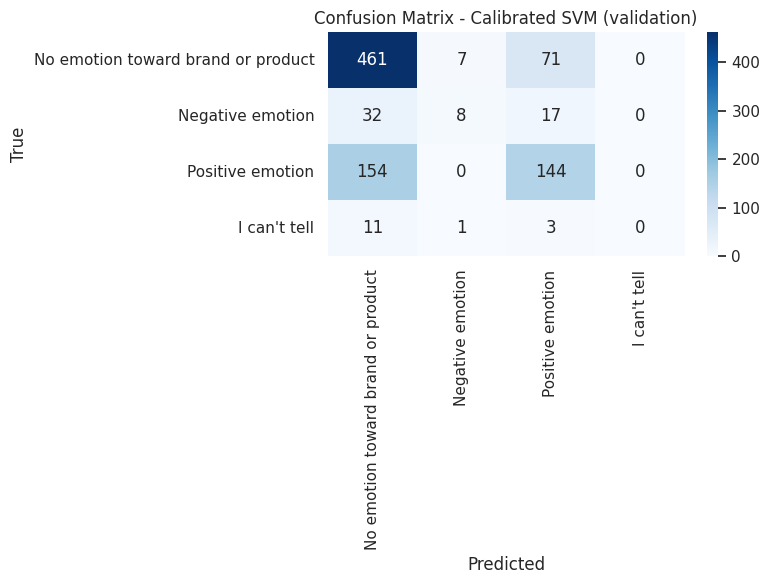

In [60]:
# Confusion matrix (final)
labels = list(pd.Series(y_train).unique())
cm = confusion_matrix(y_val, y_val_pred_cal, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Calibrated SVM (validation)")
plt.tight_layout()
plt.show()

## Top tokens (model interpretability)

For stakeholder transparency, extract top positive/negative tokens per class using logistic regression coefficients on the baseline TF-IDF (multinomial).

In [61]:
# Interpretability: top tokens per class from baseline (multinomial LR)
# baseline_pipe has tfidf and logistic regression fitted earlier
tfidf_baseline = baseline_pipe.named_steps["tfidf"]
clf_baseline = baseline_pipe.named_steps["clf"]

feature_names = tfidf_baseline.get_feature_names_out()
if hasattr(clf_baseline, "coef_"):
    coefs = clf_baseline.coef_  # shape: (n_classes, n_features)
    classes = clf_baseline.classes_
    print("Top tokens per class (baseline logistic regression):")
    for i, cls in enumerate(classes):
        topn = np.argsort(coefs[i])[-15:][::-1]
        toks = [feature_names[j] for j in topn]
        print(f"\n{cls}:")
        print(", ".join(toks))
else:
    print("Baseline classifier has no coef_ attribute to inspect.")

Top tokens per class (baseline logistic regression):

I can't tell:
en, another, gave, 2day, circles, email, down, stock, form, fragmentation, fine, holy, killer, temptation, take

Negative emotion:
iphone, hate, suck, quot, battery, kinda, headaches, over, design, apple, because, glad, sucks, fascist, swisher

No emotion toward brand or product:
link, amp, and, from, major, with, new, what, free, you, know, hashtag_google, at, talk, pop

Positive emotion:
cool, great, awesome, love, nice, get, new, time, smart, free, just, fun, hashtag_apple, major, must


## Misclassified examples for stakeholder review

Show a sample of misclassified tweets and the predicted vs true labels to help stakeholders understand common failure modes.

In [62]:
# Misclassified examples (final model)
preds = y_val_pred_cal
mis_idx = [i for i,(p,t) in enumerate(zip(preds, y_val)) if p != t]
print("Total misclassified on validation:", len(mis_idx))
# show up to 12 misclassified examples
for i in mis_idx[:12]:
    print("-" * 80)
    print("Text:", X_val[i])
    print("True:", y_val[i], "| Pred:", preds[i])

Total misclassified on validation: 296
--------------------------------------------------------------------------------
Text: rt @user we're wondering how many @user will come back from hashtag_sxsw with ipad 2's maybe everyone
True: Positive emotion | Pred: No emotion toward brand or product
--------------------------------------------------------------------------------
Text: apple popup store is still under constuction that's not keeping a 50 line of people standing in line for it hashtag_sxsw
True: No emotion toward brand or product | Pred: Positive emotion
--------------------------------------------------------------------------------
Text: it is never more apparent than at hashtag_sxsw how nice it would be if apple made stuff w removable batteries hashtag_alwayshavingtoplugin hashtag_gsdm
True: Negative emotion | Pred: Positive emotion
--------------------------------------------------------------------------------
Text: rt @user at hashtag_sxsw we're giving away an ipad 2 to th

## Calibration curve and probability distribution

Plot calibration curve and predicted probability distributions to show model confidence.

In [63]:
# Calibration and probability distribution (take one class vs rest as example)
# We'll compute calibrated probs and plot reliability for the class with highest support
probs = final_pipe.predict_proba(X_val)  # shape (n_samples, n_classes)
# Find largest class to plot
class_counts = pd.Series(y_train).value_counts()
top_class = class_counts.index[0]
class_idx = list(calibrator.classes_).index(top_class)

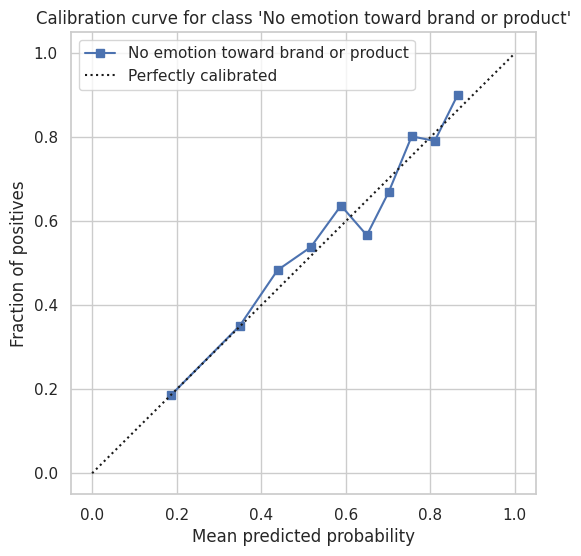

In [64]:
# Calibration curve
y_true_bin = (np.array(y_val) == top_class).astype(int)
prob_pos = probs[:, class_idx]
frac_pos, mean_pred = calibration_curve(y_true_bin, prob_pos, n_bins=10, strategy='quantile')

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, "s-", label=f"{top_class}")
plt.plot([0,1],[0,1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Calibration curve for class '{top_class}'")
plt.legend()
plt.grid(True)
plt.show()

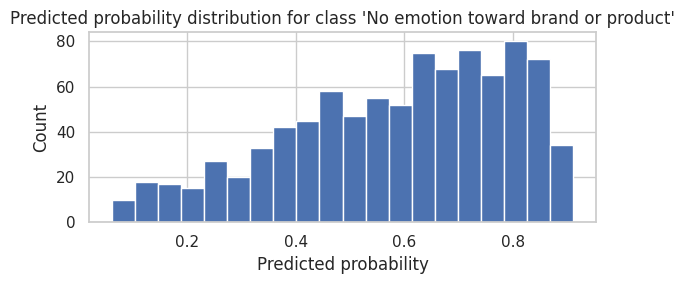

In [65]:
# Probability histogram
plt.figure(figsize=(6,3))
plt.hist(prob_pos, bins=20)
plt.title(f"Predicted probability distribution for class '{top_class}'")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Final test-set evaluation

Evaluate the chosen final pipeline on the hold-out test set and save a concise report for stakeholders.

In [66]:
# Evaluate on hold-out test set
X_test_arr = X_test
y_test_arr = y_test

y_test_pred = final_pipe.predict(X_test_arr)
test_report = classification_report(y_test_arr, y_test_pred, output_dict=True)
test_summary = {
    "accuracy": accuracy_score(y_test_arr, y_test_pred),
    "f1_macro": f1_score(y_test_arr, y_test_pred, average="macro")
}
print("Test summary:", test_summary)
print("\nClassification report (test):")
print(classification_report(y_test_arr, y_test_pred, digits=4))

# Save report
with open(SAVEDIR / "test_report.json", "w") as f:
    json.dump({"summary": test_summary, "report": test_report}, f, indent=2)

Test summary: {'accuracy': 0.7054945054945055, 'f1_macro': 0.4463349564857024}

Classification report (test):
                                    precision    recall  f1-score   support

                      I can't tell     0.0000    0.0000    0.0000        16
                  Negative emotion     0.7391    0.2982    0.4250        57
No emotion toward brand or product     0.7090    0.8905    0.7895       539
                  Positive emotion     0.6905    0.4866    0.5709       298

                          accuracy                         0.7055       910
                         macro avg     0.5347    0.4188    0.4463       910
                      weighted avg     0.6924    0.7055    0.6812       910



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## Save artifacts

Save TF-IDF, calibrated model, and a short run-summary for reproducibility and deployment.

In [67]:
# Save artifacts
joblib.dump(tfidf, SAVEDIR / "tfidf_best_svm.joblib")
joblib.dump(calibrator, SAVEDIR / "calibrated_svm_estimator.joblib")
# Note: calibrated estimator expects tfidf features; we saved both.

run_summary = {
    "chosen_model": "calibrated_svm",
    "cv_folds": CV_FOLDS,
    "random_state": RANDOM_STATE,
    "train_size": len(X_train),
    "validation_size": len(X_val),
    "test_size": len(X_test),
    "class_distribution_train": pd.Series(y_train).value_counts().to_dict(),
    "validation_metrics": {
        "accuracy": accuracy_score(y_val, y_val_pred_cal),
        "f1_macro": f1_score(y_val, y_val_pred_cal, average="macro")
    },
    "test_metrics": test_summary
}

with open(SAVEDIR / "run_summary.json", "w") as f:
    json.dump(run_summary, f, indent=2)

print("Artifacts saved to", SAVEDIR.resolve())

Artifacts saved to /content/artifacts


## Short stakeholder summary

Print an  executive summary for stakeholders describing what was built and next recommended actions.

In [68]:
# Stakeholder summary (short)
print("EXECUTIVE SUMMARY")
print("-----------------")
print(f"Dataset: {len(df)} tweets; Classes: {', '.join(allowed_labels)}")
print(f"Final model: Calibrated LinearSVC on TF-IDF (word n-grams).")
print(f"Validation F1-macro: {f1_score(y_val, y_val_pred_cal, average='macro'):.4f}")
print(f"Test F1-macro: {test_summary['f1_macro']:.4f}")
print("Recommended next steps: monitor model confidence, route low-confidence cases to manual triage, collect more labeled negatives for balance.")

EXECUTIVE SUMMARY
-----------------
Dataset: 9092 tweets; Classes: No emotion toward brand or product, Positive emotion, Negative emotion, I can't tell
Final model: Calibrated LinearSVC on TF-IDF (word n-grams).
Validation F1-macro: 0.3824
Test F1-macro: 0.4463
Recommended next steps: monitor model confidence, route low-confidence cases to manual triage, collect more labeled negatives for balance.
